# How To: Land-Use-Land-Cover Prediction for Slovenia: Part 1

This notebook shows the first steps towards constructing a machine learning pipeline for predicting the land use and land cover for the region of Republic of Slovenia.

The example uses the python package [`eo-learn`](https://github.com/sentinel-hub/eo-learn), a collection of open source Python packages that have been developed to seamlessly access and process spatio-temporal image sequences, acquired by any satellite fleet in a timely and automatic manner.

In this example, we will use satellite images obtained by ESA's Sentinel-2 to train our model and use them for prediction. The example will lead you through the whole process of creating the pipeline, with details provided at each step.

### Requirements

Currently the development version of `eolearn` is needed. 

In order to run the example you'll need a Sentinel Hub account. You can get a trial version [here](https://www.sentinel-hub.com).

Once you have the account set up, login to [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/). By default you will already have the default configuration with an **instance ID** (alpha-numeric code of length 36). For this tutorial it is recommended that you create a new configuration (`"Add new configuration"`) and set the configuration to be based on **Python scripts template**. Such configuration will already contain all layers used in these examples. Otherwise you will have to define the layers for your  configuration yourself.

After you have decided which configuration to use, you have two options You can either put configuration's **instance ID** into `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html) or you can write it down in the example notebooks.

### Outline of the Example
1. Define the Area-of-Interest (AOI):
   * Obtain the outline of Slovenia (provided)
   * Split into manageable smaller tiles
   * Select a small 3x3 area for classification
2. Use the integrated [`sentinelhub-py`](https://github.com/sentinel-hub/sentinelhub-py) package in order to fill the EOPatches with some content (band data, cloud masks, ...)
   * Define the time interval (this example uses the whole year of 2017)
3. Add additional information from band combinations (norm. vegetation index - NDVI, norm. water index - NDWI)
___________________________________

Let's start!

In [1]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Basics of Python data handling and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from shapely.geometry import Polygon

# Basics of GIS
import geopandas as gpd

# The core of this example
from eolearn.core import EOTask, EOPatch, LinearWorkflow, EOWorkflow, FeatureType, Dependency, OverwritePermission, LoadFromDisk, SaveToDisk
from eolearn.io import S2L1CWCSInput
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

# Misc
import pickle
import sys
import os
import datetime
import itertools
from tqdm import tqdm_notebook as tqdm

## 1. Define the Area-of-Interest (AOI):

* The defintion of Slovenia was taken from [here](http://www.naturalearthdata.com/downloads/10m-cultural-vectors/) and a buffer was added: `example_data/svn_buffered.geojson`
* Convert it to selected CRS: taken to be the CRS of central UTM tile (UTM_33N)
* Split into smaller, manageable, non-overlapping rectangular tiles
* Select a small 3x3 area for classification

### Get country boundary

Dimension of the area is 249870 x 171656 m2


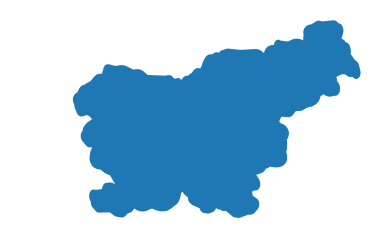

In [2]:
# Load geojson file
country = gpd.read_file('../../example_data/svn_buffered.geojson')

# Convert CRS to UTM_33N
country_crs = CRS.UTM_33N
country = country.to_crs(crs={'init':CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values.tolist()[-1]

# Plot country
country.plot()
plt.axis('off');

# Print size 
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2]-country_shape.bounds[0],country_shape.bounds[3]-country_shape.bounds[1]))

### Split to smaller tiles and choose a 3x3 area

The above size of 249870 x 171656 m2 suggests a rough splitting of 25 (columns) x 17 (rows). However, the splitting choice depends on the available resources of your computer, so two options are presented in the following. A 3x3 EOPatch sample, where each EOPatch has around 1000 x 1000 pixels at 10 meter resolution (~3 GB per EOPatch), or a sample with about 330 x 330 pixels at 10 meter resolution (~300 MB per EOPatch).

Two options are provided, so make a choice.

In [3]:
use_smaller_patches = True

# Create the splitter to obtain a list of bboxes
bbox_splitter_large = BBoxSplitter([country_shape], country_crs, (25, 17))
bbox_splitter_small = BBoxSplitter([country_shape], country_crs, (25*3, 17*3))

bbox_splitter = bbox_splitter_small if use_smaller_patches else bbox_splitter_large

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# For the future examples, we will be using a specific set of patches,
# but you are free to change the patch ID numbers in the scope of this example
# Select a central patch
ID = 1549 if use_smaller_patches else 190 

# Obtain surrounding patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)

# Check if final size is 3x3
if len(patchIDs) != 9:
    print('Warning! Use a different central patch ID, this one is on the border.')
    
# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3,3))).ravel()
    
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]
df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
gdf = gpd.GeoDataFrame(df, 
                       crs={'init':CRS.ogc_string(country_crs)}, 
                       geometry=geometry)

### Visualize the selection

In [4]:
poly = gdf['geometry'][0]
x1,y1,x2,y2 = poly.bounds
aspect_ratio = (y1-y2)/(x1-x2)

(357737.03586605104, 632593.8219180192, 5016135.9977509845, 5204957.80695405)

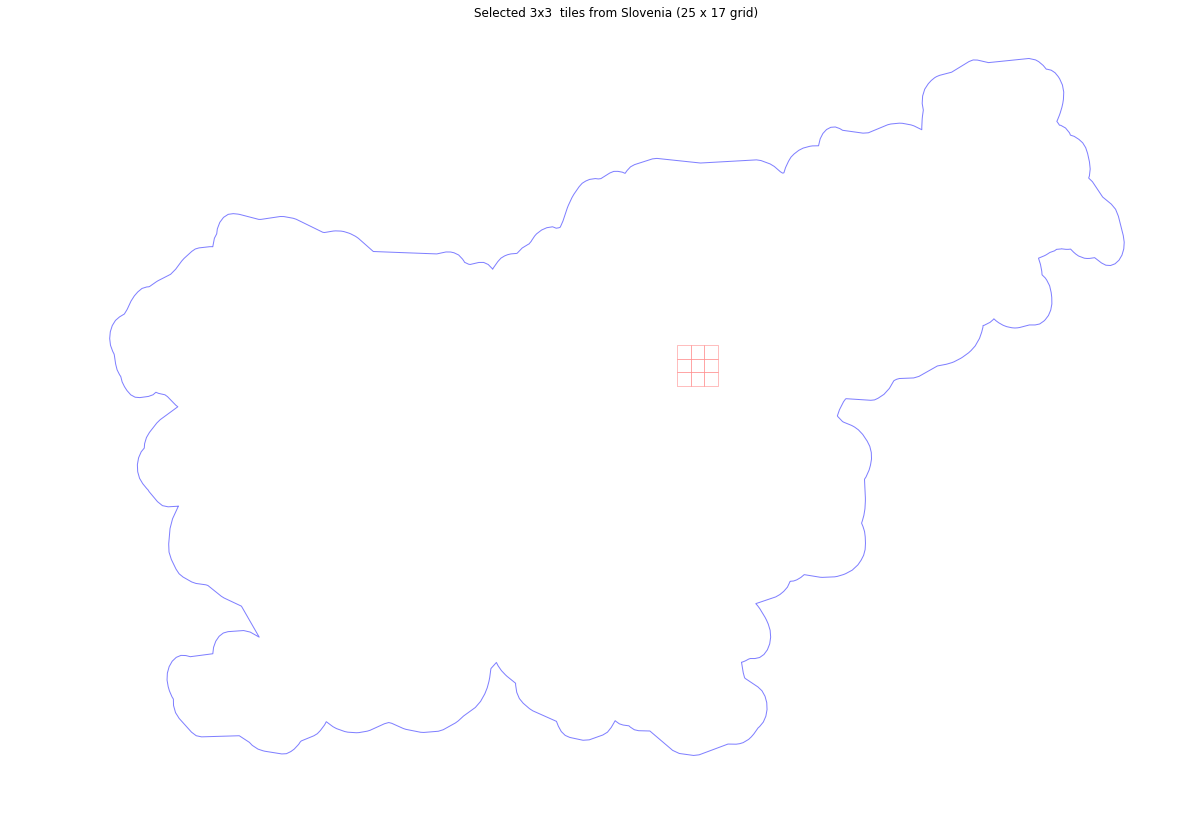

In [5]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu-xl)/3, (yu-yl)/5

# figure
fig, ax = plt.subplots(figsize=(20,20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 3x3  tiles from Slovenia (25 x 17 grid)');
plt.axis('off')

## 2. - 4. Fill EOPatches with data:

Now it's time to create EOPatches and fill them with Sentinel-2 data using Sentinel Hub services. We will add the following data to each EOPatch
* L1C custom list of bands
   * [B02, B03, B04, B08, B11, B12], which corresponds to
   * [B, G, R, NIR, SWIR1, SWIR2]
* SentinelHub's cloud probability map and cloud mask

Additionally, we will add
* Calculated NDVI, NDWI, euclidean NORM information
* A mask of validity, based on acquired data from sentinel and cloud coverage
   * Valid pixel is if:
      * IS_DATA == True
      * CLOUD_MASK == 0 (1 indicates that pixel was identified to be covered with cloud)

An EOPatch is created and manipulated using EOTasks, which are chained in an EOWorkflow. In this example the final workflow is executed on all patches, which are saved to the specified directory.

### Define some needed custom EOTasks

In [6]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))
    
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch


class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name=feature_name
        self.band_a_fetaure_name=band_a.split('/')[0]
        self.band_b_fetaure_name=band_b.split('/')[0]
        self.band_a_fetaure_idx=int(band_a.split('/')[-1])
        self.band_b_fetaure_idx=int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        
        ndi = (band_a-band_b)/(band_a+band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[...,np.newaxis])
        
        return eopatch

    
class EuclideanNorm(EOTask):   
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name=feature_name
        self.in_feature_name=in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[...,np.newaxis])
        return eopatch

### Define the workflow tasks

In [7]:
# save to output?
# recommended if you have memory issues
save_choice = True  

# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12) 
# from default layer 'ALL_BANDS' at 10m resolution
custom_script = 'return [B02, B03, B04, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='ALL_BANDS', 
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution 
# and the resulting cloud probability map and mask 
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m', 
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition 
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask 
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
if not os.path.isdir(path_out) and save_choice:
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

Finished loading model, total used 170 iterations


### Define the workflow

All the tasks that were defined so far create and fill the EOPatches. The tasks need to be put in some order and executed one by one. This can be achieved by manually executing the tasks, or more conveniently, defining an `EOWorkflow` which does this for you.

The following workflow is created and executed:
1. Create EOPatches with band data
2. Add cloud info
3. Calculate and add NDVI, NDWI, NORM
4. Add mask of valid pixels
5. Add scalar feature representing the cound of valid pixels
7. Save eopatches

Define the workflow

In [8]:
if save_choice:
    save_task = [save]
else:
    save_task = []

# Define the workflow
workflow = LinearWorkflow(
    add_data,
    add_clm,
    ndvi,
    ndwi,
    norm,
    add_sh_valmask,
    count_val_sh,
    *save_task
)

_This may take some time, so go grab a cup of coffee ..._

In [9]:
%%time

# Execute the workflow
eopatches = [] # container for the full eopatches
time_interval = ['2017-01-01','2017-12-31'] # time interval for the SH request

# Show progress bar 
pbar = tqdm(total=len(patchIDs))
for idx, bbox in enumerate(bbox_list[patchIDs]):
    # define additional parameters of the workflow
    extra_param = {add_data:{'bbox':bbox, 'time_interval':time_interval}}
    if save_choice:
        extra_param[save] = {'eopatch_folder': 'eopatch_{}'.format(idx)}
    
    result = workflow.execute(extra_param)    
    if save_choice:
        del result
    else:
        eopatches.append(result[list(result.keys())[-1]])
    pbar.update(1)

CPU times: user 3min 37s, sys: 22.2 s, total: 3min 59s
Wall time: 2min 26s


### Visualize the patches

Luckily, all patches come from a small region, so all of them have the same dates of acquisition for at least a few dates, so we can inspect the area without interpolation at this point.

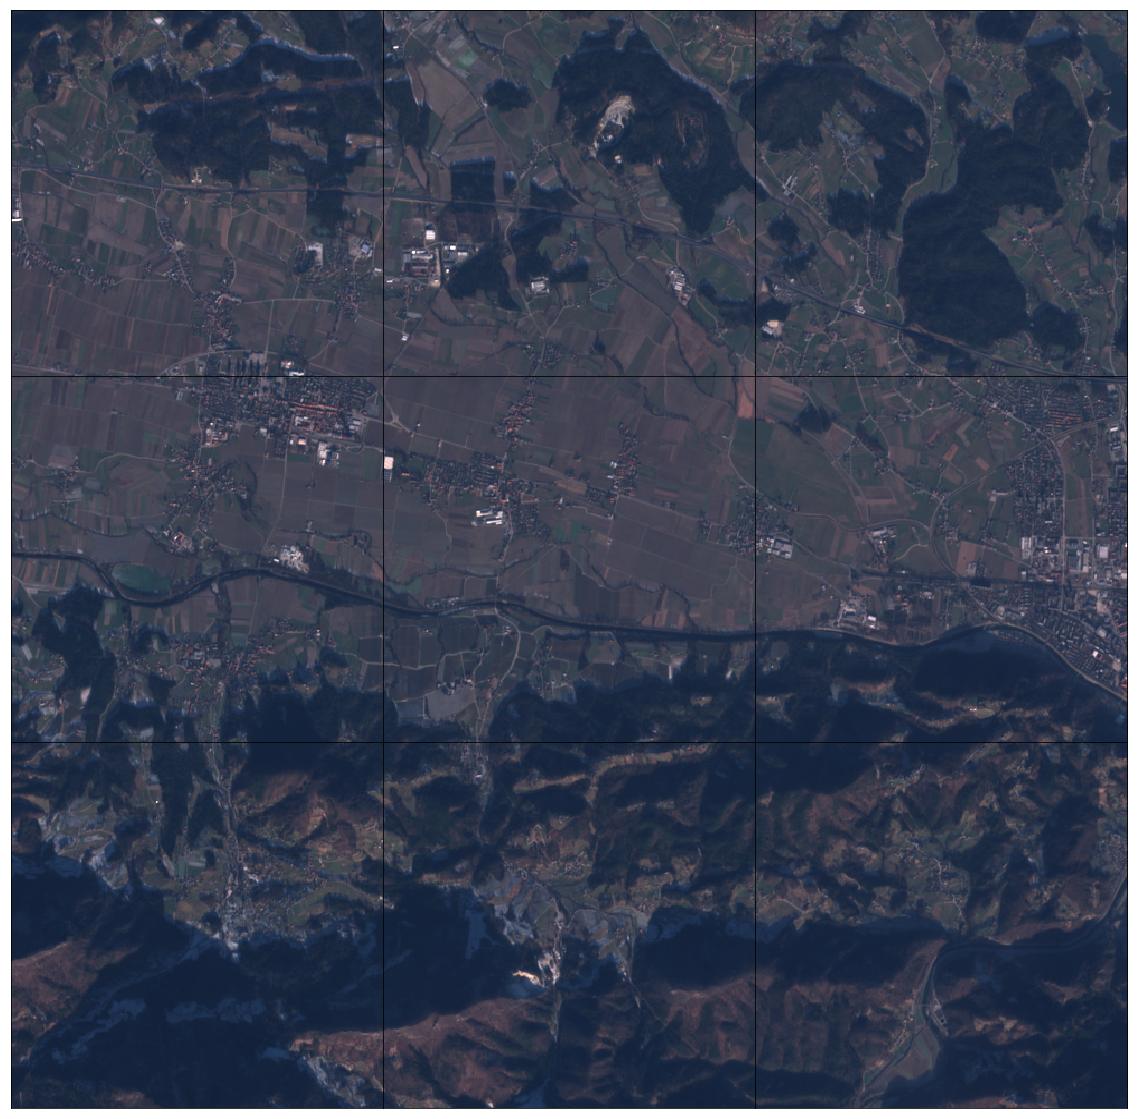

In [10]:
# Draw the RGB image
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
fig = plt.figure(figsize=(20,20*aspect_ratio))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i)) if save_choice else eopatches[i]
    ax = plt.subplot(3,3,i+1)
    plt.imshow(np.clip(eopatch.data['BANDS'][0][...,[2,1,0]]*2.5,0,1))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

### Plot the map of valid pixel counts

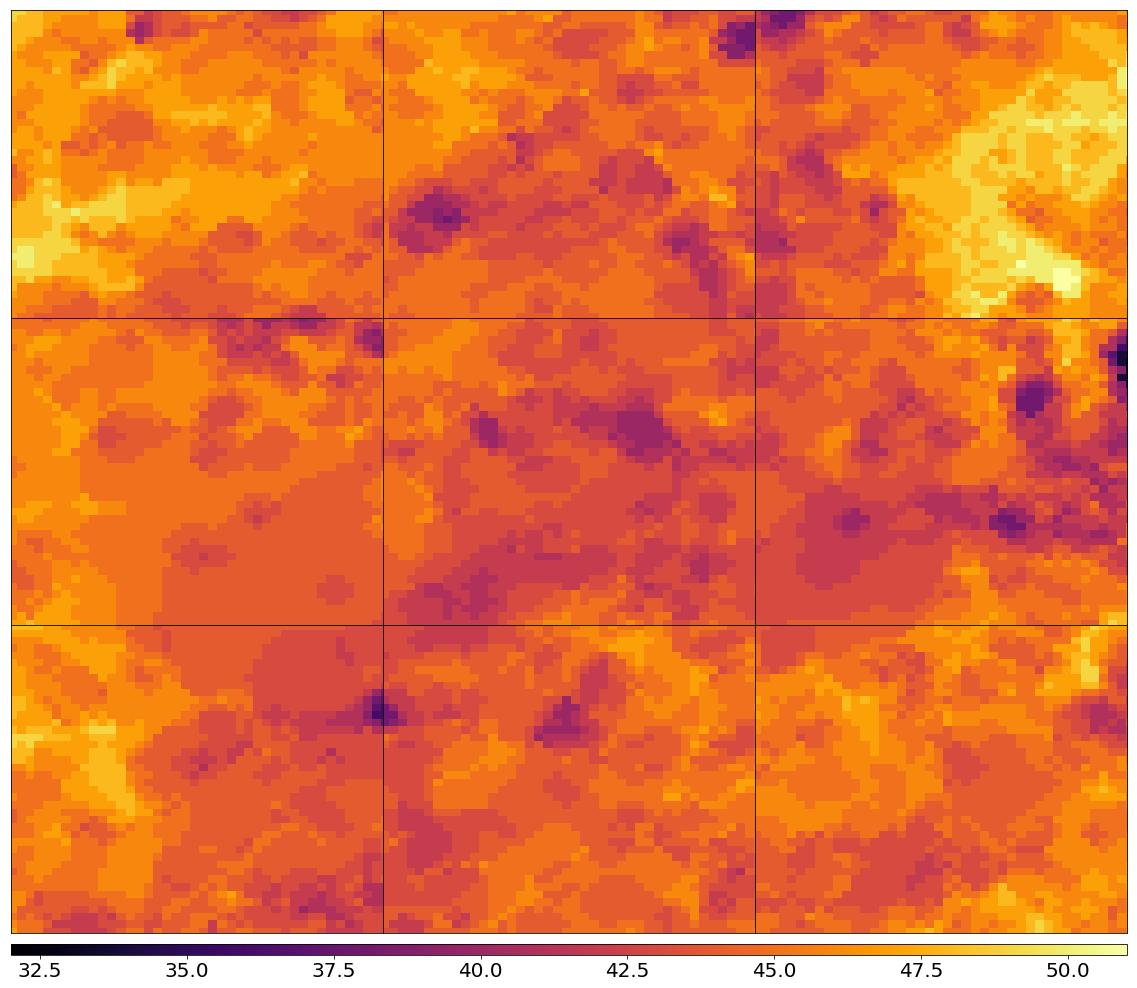

In [11]:
# Draw the RGB image
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

vmin, vmax = None, None
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i)) if save_choice else eopatches[i]
    data = eopatch.mask_timeless['VALID_COUNT'].squeeze()
    vmin = np.min(data) if vmin is None else (np.min(data) if np.min(data) < vmin else vmin)
    vmax = np.max(data) if vmax is None else (np.max(data) if np.max(data) > vmax else vmax)

fig, axes = plt.subplots(figsize=(20,20*aspect_ratio), nrows=3, ncols=3)
    
pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i)) if save_choice else eopatches[i]
    im = ax.imshow(eopatch.mask_timeless['VALID_COUNT'].squeeze(), vmin=vmin, vmax=vmax, cmap=plt.cm.inferno)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad = 0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()

### Plot the average cloud probability

Some structures can be seen like road networks etc., indicating a bias of the cloud detector towards these objects.

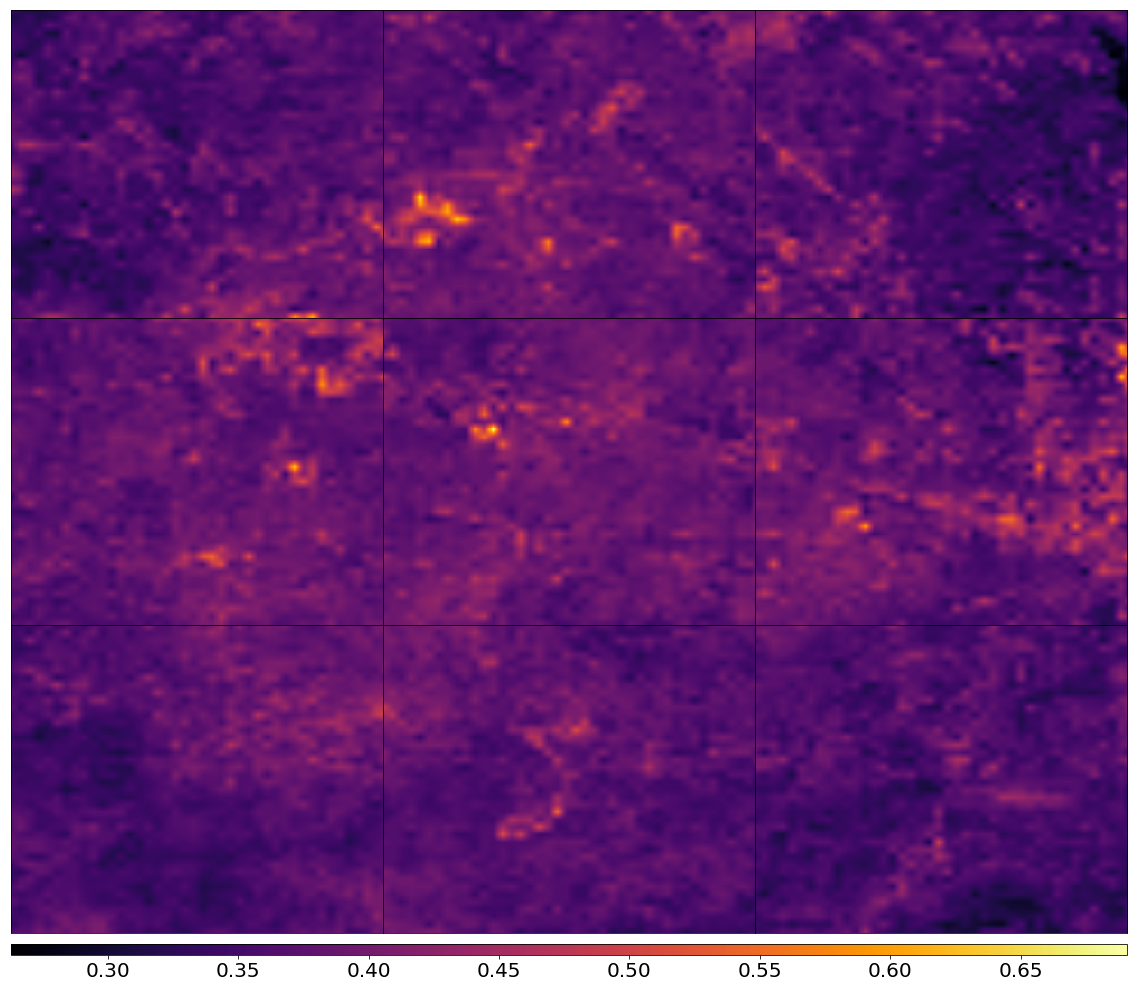

In [12]:
# Draw the RGB image
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

vmin, vmax = None, None
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i)) if save_choice else eopatches[i]
    data = (np.mean(eopatch.data['CLP'], axis=0)).squeeze()
    vmin = np.min(data) if vmin is None else (np.min(data) if np.min(data) < vmin else vmin)
    vmax = np.max(data) if vmax is None else (np.max(data) if np.max(data) > vmax else vmax)

fig, axes = plt.subplots(figsize=(20,20*aspect_ratio), nrows=3, ncols=3)
    
pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i)) if save_choice else eopatches[i]
    im = ax.imshow((np.mean(eopatch.data['CLP'], axis=0)).squeeze(), vmin=vmin, vmax=vmax, cmap=plt.cm.inferno)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad = 0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()